In [238]:
import pandas as pd
import gzip as gz
import matplotlib.pyplot as plt
import sqlite3
import os
import zipfile
import seaborn as sns
import math
import numpy as np

In [239]:
# Opened the relevant datasets to be explored in jupyter notebook
#if not os.path.exists('zippedData/im.db'):
with zipfile.ZipFile('zippedData/im.db.zip') as my_zip:
    zipfile.ZipFile.extractall(my_zip,path='zippedData/')
with gz.open('zippedData/rt.reviews.tsv.gz') as f:
    rt_reviews = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/rt.movie_info.tsv.gz') as f:
    rt_movie_info = pd.read_csv(f,delimiter='\t',encoding='latin1')
with gz.open('zippedData/tmdb.movies.csv.gz') as f:
    tmdb_movies = pd.read_csv(f)
with gz.open('zippedData/tn.movie_budgets.csv.gz') as f:
    tn_movie_budgets = pd.read_csv(f)
with gz.open('zippedData/bom.movie_gross.csv.gz') as f:
    bom_movie_gross = pd.read_csv(f)

In [240]:
# Connected to and opened the imdb database to utilize the data
im_db = sqlite3.connect('zippedData/im.db')
imdb_df = pd.read_sql("""SELECT * FROM movie_basics""",im_db)

In [241]:
# Created a SQL query to pull director name and info from the imdb database
director_info = """
SELECT
    m.movie_id,
    m.primary_title,
    m.genres,
    d.person_id,
    p.primary_name,
    p.death_year
    
    
FROM
    movie_basics AS m
    JOIN 
        directors AS d ON m.movie_id = d.movie_id
    JOIN
        known_for AS kf ON m.movie_id = kf.movie_id
    JOIN
        persons AS p ON p.person_id = d.person_id
GROUP BY
    m.movie_id, kf.person_id, p.primary_name
;
"""
director_info_result = pd.read_sql(director_info, im_db)
director_info_result

,movie_id,primary_title,genres,person_id,primary_name,death_year
0,tt0063540,Sunghursh,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,2004.0
1,tt0063540,Sunghursh,"Action,Crime,Drama",nm0712540,Harnam Singh Rawail,2004.0
2,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
3,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
4,tt0069049,The Other Side of the Wind,Drama,nm0000080,Orson Welles,1985.0
...,...,...,...,...,...,...
991711,tt9916754,Chico Albuquerque - Revelações,Documentary,nm8349149,Vinicius Augusto Bozzo,NaN
991712,tt9916754,Chico Albuquerque - Revelações,Documentary,nm9272490,Angela Gurgel,NaN
991713,tt9916754,Chico Albuquerque - Revelações,Documentary,nm8349149,Vinicius Augusto Bozzo,NaN
991714,tt9916754,Chico Albuquerque - Revelações,Documentary,nm9272490,Angela Gurgel,NaN


In [242]:
director_info_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991716 entries, 0 to 991715
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movie_id       991716 non-null  object 
 1   primary_title  991716 non-null  object 
 2   genres         973303 non-null  object 
 3   person_id      991716 non-null  object 
 4   primary_name   991716 non-null  object 
 5   death_year     5020 non-null    float64
dtypes: float64(1), object(5)
memory usage: 45.4+ MB


In [243]:
# Created a new variable that filtered the director_info_results to drop all director's who are deceased
# and to drop any duplicate movie_ids 
clean_director_info = director_info_result[director_info_result['death_year'].isnull()].drop_duplicates(['primary_title'])
clean_director_info[clean_director_info['primary_name'] == 'James Cameron']

,movie_id,primary_title,genres,person_id,primary_name,death_year
76842,tt1630029,Avatar 2,"Action,Adventure,Fantasy",nm0000116,James Cameron,NaN
115933,tt1757678,Avatar 3,"Action,Adventure,Drama",nm0000116,James Cameron,NaN
401367,tt3095356,Avatar 4,"Action,Adventure,Fantasy",nm0000116,James Cameron,NaN


In [244]:
clean_director_info.info()
bom_movie_gross.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123023 entries, 18 to 991700
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movie_id       123023 non-null  object 
 1   primary_title  123023 non-null  object 
 2   genres         120459 non-null  object 
 3   person_id      123023 non-null  object 
 4   primary_name   123023 non-null  object 
 5   death_year     0 non-null       float64
dtypes: float64(1), object(5)
memory usage: 6.6+ MB


Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')

In [245]:
tn_movie_budgets['year'] = tn_movie_budgets['release_date'].str[-4:]
tn_movie_budgets['month'] = tn_movie_budgets['release_date'].str[:3]
tn_movie_budgets['clean_budget'] = tn_movie_budgets['production_budget'].str.replace('$','')
tn_movie_budgets['clean_budget'] = tn_movie_budgets['clean_budget'].str.replace(',','').astype(int)
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['domestic_gross'].str.replace('$','')
tn_movie_budgets['clean_domestic'] = tn_movie_budgets['clean_domestic'].str.replace(',','').astype(int)
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['worldwide_gross'].str.replace('$','')
tn_movie_budgets['clean_worldwide'] = tn_movie_budgets['clean_worldwide'].str.replace(',','').astype('int64')
tn_movie_budgets['clean_foreign'] = tn_movie_budgets['clean_worldwide'] - tn_movie_budgets['clean_domestic']
tn_movie_budgets.rename({'movie':'title'},axis=1,inplace=True)
#tn_movie_budgets.info()
tn_relevant_cols = ['title','year','month','clean_budget','clean_domestic','clean_foreign','clean_worldwide']
tn_relevant = tn_movie_budgets[tn_relevant_cols]
#tn_relevant.head()

In [246]:
bom_movie_gross['foreign_gross'] = bom_movie_gross['foreign_gross'].fillna('0')
bom_movie_gross.dropna(inplace=True)
bom_movie_gross['clean_domestic'] = bom_movie_gross['domestic_gross'].astype(int)
bom_movie_gross['clean_foreign'] = bom_movie_gross['foreign_gross'].str.replace(',','').astype(float)
bom_movie_gross['clean_foreign'] = bom_movie_gross['clean_foreign'].apply(math.trunc)
bom_movie_gross['clean_worldwide'] = bom_movie_gross['clean_domestic'] + bom_movie_gross['clean_foreign']
#bom_movie_gross.info()
bom_relevant_cols = ['title','year','clean_domestic','clean_foreign','clean_worldwide', 'studio']
bom_relevant = bom_movie_gross[bom_relevant_cols]
#bom_relevant.head()

In [247]:
combined_financials = pd.concat([tn_relevant,bom_relevant],ignore_index=True)
combined_financials = combined_financials.drop_duplicates(subset='title',keep='first')
#combined_financials.plot('clean_domestic','clean_foreign',kind='scatter')

#Much of the budget column is empty because bom_movie_gross does not include budget information
#Going to fill the NA budgets with the median value
combined_financials['clean_budget'].fillna(combined_financials['clean_budget'].median(),inplace=True)
combined_financials['roi_domestic'] = 100 * (combined_financials['clean_domestic'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['roi_worldwide'] = 100 * (combined_financials['clean_worldwide'] - combined_financials['clean_budget']) / combined_financials['clean_budget']
combined_financials['clean_profit'] = combined_financials['clean_worldwide'] - combined_financials['clean_budget']
#combined_financials.head()

In [248]:
all_movie_data = clean_director_info.merge(combined_financials, left_on = 'primary_title',right_on ='title', how = 'inner')
all_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3667 entries, 0 to 3666
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         3667 non-null   object 
 1   primary_title    3667 non-null   object 
 2   genres           3656 non-null   object 
 3   person_id        3667 non-null   object 
 4   primary_name     3667 non-null   object 
 5   death_year       0 non-null      float64
 6   title            3667 non-null   object 
 7   year             3667 non-null   object 
 8   month            2260 non-null   object 
 9   clean_budget     3667 non-null   float64
 10  clean_domestic   3667 non-null   int32  
 11  clean_foreign    3667 non-null   int64  
 12  clean_worldwide  3667 non-null   int64  
 13  studio           1407 non-null   object 
 14  roi_domestic     3667 non-null   float64
 15  roi_worldwide    3667 non-null   float64
 16  clean_profit     3667 non-null   float64
dtypes: float64(5),

In [249]:
all_movie_data.head()

,movie_id,primary_title,genres,person_id,primary_name,death_year,title,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,studio,roi_domestic,roi_worldwide,clean_profit
0,tt0249516,Foodfight!,"Action,Animation,Comedy",nm0440415,Lawrence Kasanoff,NaN,Foodfight!,2012,Dec,45000000.0,0,73706,73706,NaN,-100.000000,-99.836209,-44926294.0
1,tt0293429,Mortal Kombat,"Action,Adventure,Fantasy",nm2585406,Simon McQuoid,NaN,Mortal Kombat,1995,Aug,20000000.0,70433227,51700000,122133227,NaN,252.166135,510.666135,102133227.0
2,tt0315642,Wazir,"Action,Crime,Drama",nm2349060,Bejoy Nambiar,NaN,Wazir,2016,NaN,17000000.0,1100000,0,1100000,Relbig.,-93.529412,-93.529412,-15900000.0
3,tt0326592,The Overnight,None,nm1208371,Jed I. Goodman,NaN,The Overnight,2015,Jun,200000.0,1109808,56188,1165996,NaN,454.904000,482.998000,965996.0
4,tt0337692,On the Road,"Adventure,Drama,Romance",nm0758574,Walter Salles,NaN,On the Road,2013,Mar,25000000.0,720828,8592474,9313302,NaN,-97.116688,-62.746792,-15686698.0


In [250]:
studio_and_budget_df = all_movie_data
director_and_budget_df = all_movie_data

In [251]:
studio_and_budget_df[studio_and_budget_df['studio'].isna()]

,movie_id,primary_title,genres,person_id,primary_name,death_year,title,year,month,clean_budget,clean_domestic,clean_foreign,clean_worldwide,studio,roi_domestic,roi_worldwide,clean_profit
0,tt0249516,Foodfight!,"Action,Animation,Comedy",nm0440415,Lawrence Kasanoff,NaN,Foodfight!,2012,Dec,45000000.0,0,73706,73706,NaN,-100.000000,-99.836209,-44926294.0
1,tt0293429,Mortal Kombat,"Action,Adventure,Fantasy",nm2585406,Simon McQuoid,NaN,Mortal Kombat,1995,Aug,20000000.0,70433227,51700000,122133227,NaN,252.166135,510.666135,102133227.0
3,tt0326592,The Overnight,None,nm1208371,Jed I. Goodman,NaN,The Overnight,2015,Jun,200000.0,1109808,56188,1165996,NaN,454.904000,482.998000,965996.0
4,tt0337692,On the Road,"Adventure,Drama,Romance",nm0758574,Walter Salles,NaN,On the Road,2013,Mar,25000000.0,720828,8592474,9313302,NaN,-97.116688,-62.746792,-15686698.0
5,tt0359950,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",nm0001774,Ben Stiller,NaN,The Secret Life of Walter Mitty,2013,Dec,91000000.0,58236838,129624345,187861183,NaN,-36.003475,106.440860,96861183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3662,tt9607270,The Blue Bird,Drama,nm10403402,Kwiduck Lee,NaN,The Blue Bird,1976,Jan,1200000.0,887000,0,887000,NaN,-26.083333,-26.083333,-313000.0
3663,tt9678962,Fuel,"Documentary,Sport",nm3868049,Maarten Wijsman,NaN,Fuel,2008,Nov,2500000.0,174255,0,174255,NaN,-93.029800,-93.029800,-2325745.0
3664,tt9691476,Snow White and the Seven Dwarfs,"Comedy,Drama,Fantasy",nm10441208,Paul Hendy,NaN,Snow White and the Seven Dwarfs,1937,Dec,1488000.0,184925486,0,184925486,NaN,12327.788038,12327.788038,183437486.0
3665,tt9729206,Diner,Crime,nm2242451,Mika Ninagawa,NaN,Diner,1982,Apr,5000000.0,12592907,0,12592907,NaN,151.858140,151.858140,7592907.0


In [252]:
studio_and_budget_df.dropna(subset=['studio'], inplace = True)

In [253]:
director_and_budget_df.dropna(subset=['primary_name'], inplace = True)

In [254]:
studio_and_budget_df['studio'].value_counts()[:30]

IFC        100
Magn.       86
Eros        66
SPC         66
Strand      49
KL          45
WGUSA       43
CJ          41
CL          39
UTV         36
MBox        35
Cohen       32
RAtt.       31
FM          31
Wein.       26
LGF         24
A24         21
FIP         18
Osci.       17
BV          16
FoxS        16
Drft.       16
GK          16
Gold.       15
Focus       14
Zeit.       12
Relbig.     12
Sony        12
EOne        12
Uni.        12
Name: studio, dtype: int64

In [255]:
top_30_studio_names = list(studio_and_budget_df['studio'].value_counts()[:30].index)
# print(top_30_studio_names)
movies_df_from_top30 = studio_and_budget_df[studio_and_budget_df['studio'].isin(top_30_studio_names)]
# movies_df_from_top30.head()

In [256]:
'''top_10_director_names = list(director_and_budget_df['primary_name'].value_counts()[:10].index)
# print(top_30_studio_names)
director_df_from_top30 = director_and_budget_df[director_and_budget_df['primary_name'].isin(top_30_director_names)]
director_df_from_top30.head()
'''

"top_10_director_names = list(director_and_budget_df['primary_name'].value_counts()[:10].index)\n# print(top_30_studio_names)\ndirector_df_from_top30 = director_and_budget_df[director_and_budget_df['primary_name'].isin(top_30_director_names)]\ndirector_df_from_top30.head()\n"

In [257]:
studio_means = movies_df_from_top30.groupby('studio').mean().sort_values('clean_worldwide',ascending=False)

In [258]:
# director_means = director_df_from_top30.groupby('primary_name').mean().sort_values('clean_worldwide',ascending=False)

In [259]:
studio_means.head()

,death_year,clean_budget,clean_domestic,clean_foreign,clean_worldwide,roi_domestic,roi_worldwide,clean_profit
studio,,,,,,,,
BV,NaN,17000000.0,1.042812e+08,1.489632e+08,2.532444e+08,513.419117,1389.673161,2.362444e+08
Uni.,NaN,17000000.0,6.435183e+07,1.369333e+08,2.012852e+08,278.540196,1084.030392,1.842852e+08
WGUSA,NaN,17000000.0,4.470163e+05,5.302435e+07,5.347137e+07,-97.370492,214.537442,3.647137e+07
LGF,NaN,17000000.0,1.362822e+07,2.790262e+07,4.153085e+07,-19.833971,144.299118,2.453085e+07
Sony,NaN,17000000.0,3.004333e+06,3.572500e+07,3.872933e+07,-82.327451,127.819608,2.172933e+07


In [260]:
#director_means.head()
#print(top_30_director_names)
print(studio_and_budget_df['studio'].value_counts().index)


Index(['IFC', 'Magn.', 'Eros', 'SPC', 'Strand', 'KL', 'WGUSA', 'CJ', 'CL',
       'UTV',
       ...
       'CLF', 'EXCL', 'Pala.', 'Rela.', 'B360', 'RME', 'Asp.', 'Zee', 'LD',
       'Blue Fox'],
      dtype='object', length=191)


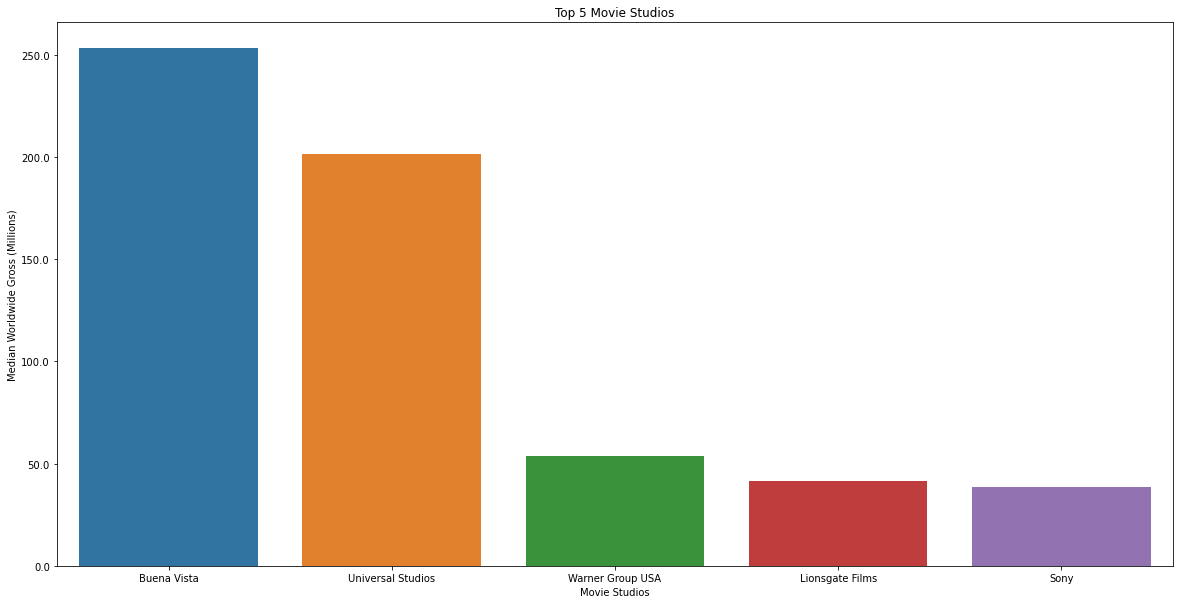

In [266]:
fig, ax = plt.subplots(figsize =(20,10))


sns.barplot(x = ['Buena Vista', 'Universal Studios', 'Warner Group USA', 'Lionsgate Films', 'Sony'], y =studio_means['clean_worldwide'][:5])
fig.patch.set_facecolor('xkcd:white')
ax.set(xlabel = 'Movie Studios', title = 'Top 5 Movie Studios')
ax.set_ylabel('Median Worldwide Gross (Millions)')
ax.set_yticklabels(ax.get_yticks()//1000000);

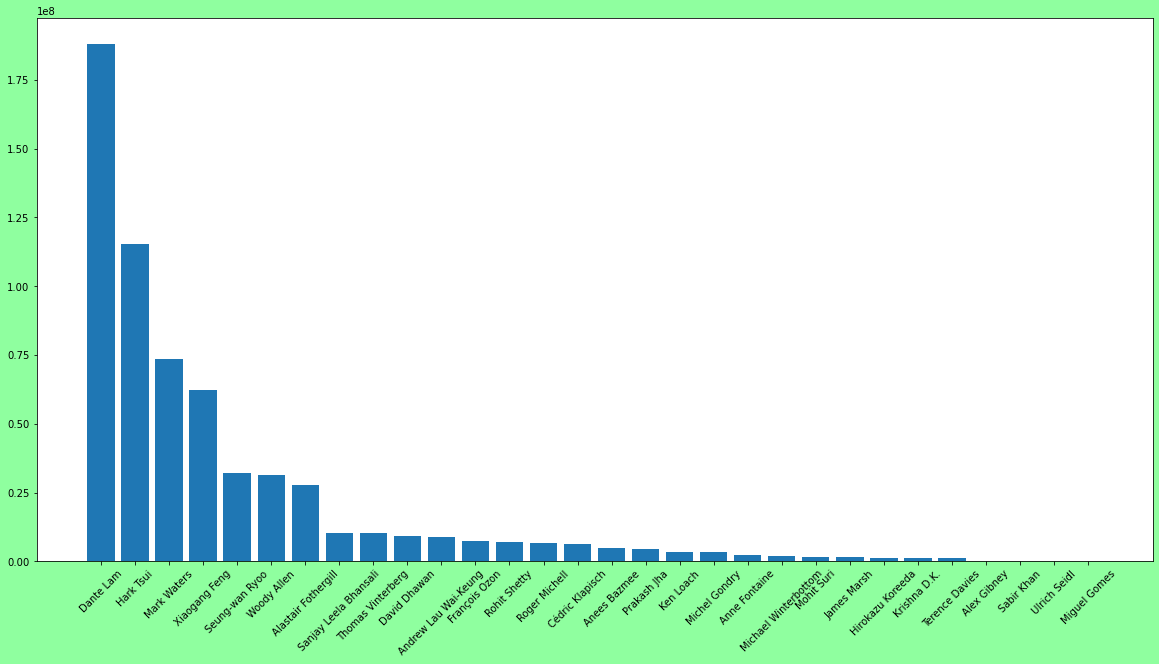

In [262]:
fig2, ax2 = plt.subplots(figsize =(20,10))

ax2.bar(x = director_means.index, height=director_means['clean_worldwide'])
fig2.patch.set_facecolor('xkcd:mint green')
plt.xticks(rotation=45);

In [263]:
clean_director_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123023 entries, 18 to 991700
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movie_id       123023 non-null  object 
 1   primary_title  123023 non-null  object 
 2   genres         120459 non-null  object 
 3   person_id      123023 non-null  object 
 4   primary_name   123023 non-null  object 
 5   death_year     0 non-null       float64
dtypes: float64(1), object(5)
memory usage: 6.6+ MB
